In [19]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [20]:
df = pd.read_excel('groups1.xlsx', sheet_name='ttps')
df = df.drop(columns=['source name', 'source ref', 'source type', 'mapping type', 'target name', 'target ref', 'target type', 'mapping description', 'STIX ID'])

df.head()

,sourceID,targetID,created,last modified
0,G0099,T1105,07 May 2020,14 October 2020
1,G0099,T1204.002,05 May 2020,14 October 2020
2,G0099,T1036.004,07 May 2020,14 October 2020
3,G0099,T1571,05 May 2020,14 October 2020
4,G0099,T1027,05 May 2020,14 October 2020


In [21]:
# Create a default dictionary to hold the desired structure
grouped_data = defaultdict(dict)

# Iterate through each row to populate the dictionary
for index, row in df.iterrows():
    # Using targetID as key and a tuple (created, last_modified) as value for each sourceID
    grouped_data[row['sourceID']][row['targetID']] = [row['created'][-4:], row['last modified'][-4:]]

# Convert the default dictionary to a regular dictionary if needed
grouped_data = dict(grouped_data)

# To create a DataFrame from this structure
# First, we prepare a list of tuples representing each row
rows_list = [(sourceID, targets) for sourceID, targets in grouped_data.items()]
# Create a new DataFrame
new_df = pd.DataFrame(rows_list, columns=['sourceID', 'Targets'])

print(new_df)

    sourceID                                            Targets
0      G0099  {'T1105': ['2020', '2020'], 'T1204.002': ['202...
1      G0006  {'T1560.001': ['2017', '2020'], 'T1119': ['201...
2      G0005  {'T1102.002': ['2019', '2020'], 'T1568.003': [...
3      G0023                    {'T1584.004': ['2020', '2022']}
4      G0025  {'T1585': ['2020', '2020'], 'T1583.006': ['202...
..       ...                                                ...
133    G0044  {'T1553.002': ['2017', '2019'], 'T1583.001': [...
134    G0102  {'T1560.001': ['2023', '2023'], 'T1197': ['202...
135    G0128  {'T1102.002': ['2021', '2021'], 'T1555.003': [...
136    G0018  {'T1203': ['2019', '2019'], 'T1083': ['2017', ...
137    G0045  {'T1560': ['2019', '2020'], 'T1560.001': ['201...

[138 rows x 2 columns]


1. Trend Analysis: 
Identify how the activity of different threat actors has evolved over time. This can involve counting the number of new techniques adopted by each actor over time or the changes in their techniques.

In [22]:
# Extract years when each technique was adopted
def extract_years(target_dict):
    return {target: dates[0] for target, dates in target_dict.items()}

new_df['Start_Years'] = new_df['Targets'].apply(extract_years)

# Flatten the DataFrame to have one row per sourceID and target
rows = []
for _, row in new_df.iterrows():
    for target, year in row['Start_Years'].items():
        rows.append({'sourceID': row['sourceID'], 'Target': target, 'Year': year})

flat_df = pd.DataFrame(rows)

# Count the number of new techniques per year for each sourceID
trend_analysis = flat_df.groupby(['sourceID', 'Year']).size().reset_index(name='New Techniques')

print(trend_analysis.sort_values(by='New Techniques', ascending=False))


    sourceID  Year  New Techniques
89     G0034  2020              57
94     G0035  2021              54
332    G1016  2023              53
263    G0102  2020              45
323    G1006  2022              44
..       ...   ...             ...
260    G0099  2021               1
162    G0060  2021               1
164    G0061  2020               1
257    G0098  2021               1
168    G0063  2018               1

[336 rows x 3 columns]


2. Time Series Analysis: 
For each threat actor or technique, analyze the frequency of occurrence over time to identify any seasonal patterns or trends.

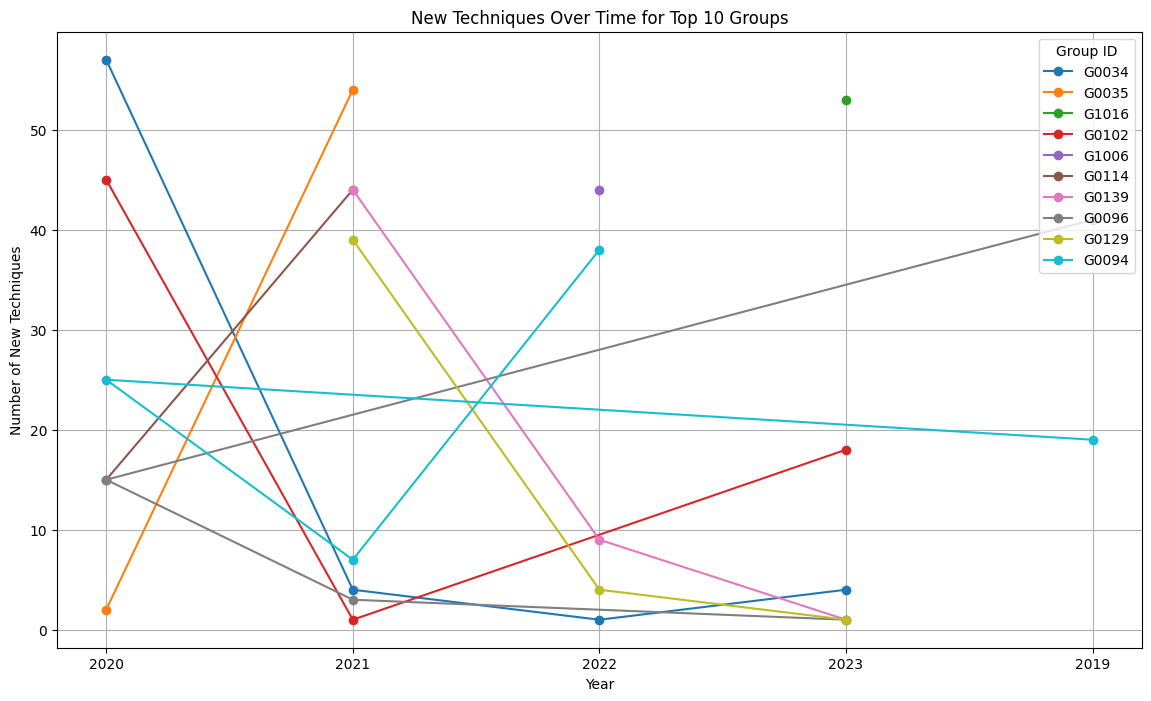

In [23]:
top_10_groups = trend_analysis.sort_values(by='New Techniques', ascending=False).head(10)
plt.figure(figsize=(14, 8))

# Iterate through the top 10 groups
for sourceID in top_10_groups['sourceID']:
    group_data = trend_analysis[trend_analysis['sourceID'] == sourceID]
    
    # Plot each group's data
    plt.plot(group_data['Year'], group_data['New Techniques'], marker='o', label=sourceID)

plt.title("New Techniques Over Time for Top 10 Groups")
plt.xlabel('Year')
plt.ylabel('Number of New Techniques')
plt.grid(True)
plt.legend(title="Group ID")
plt.show()

3. Survival Analysis: 
Assess the "lifetime" of specific techniques within groups to see how long they stay relevant or are actively used before being modified or dropped.

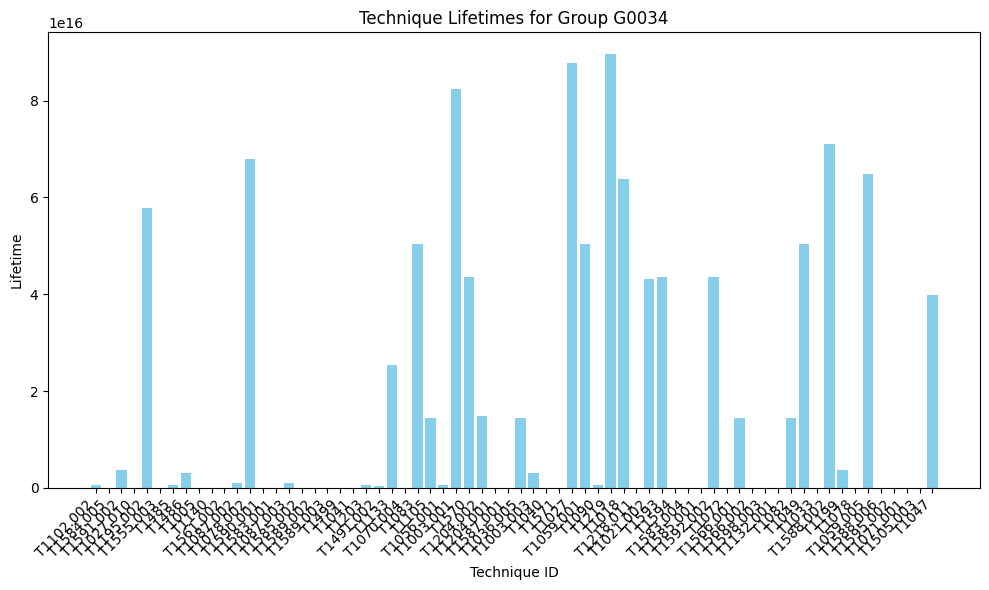

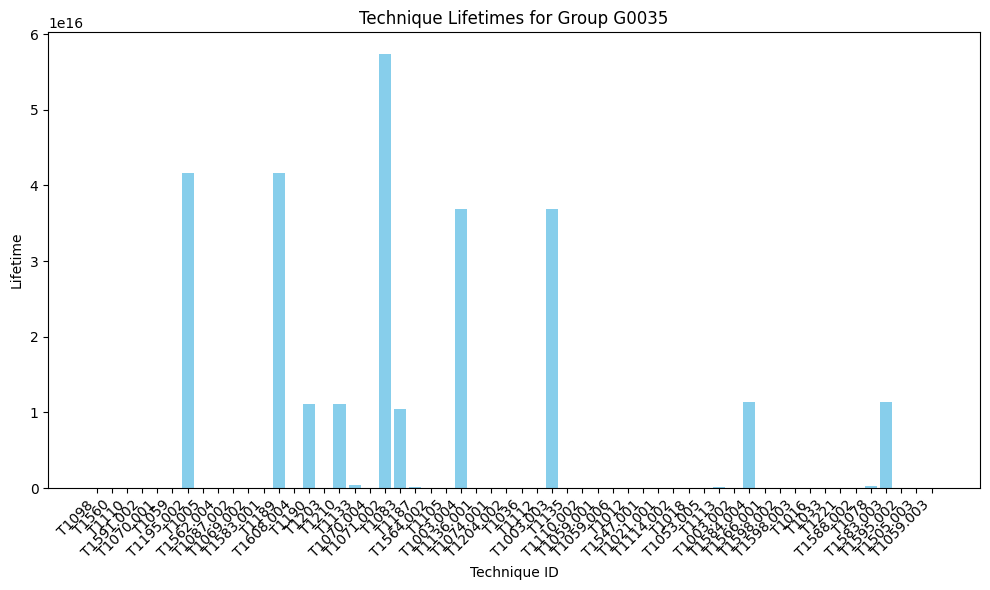

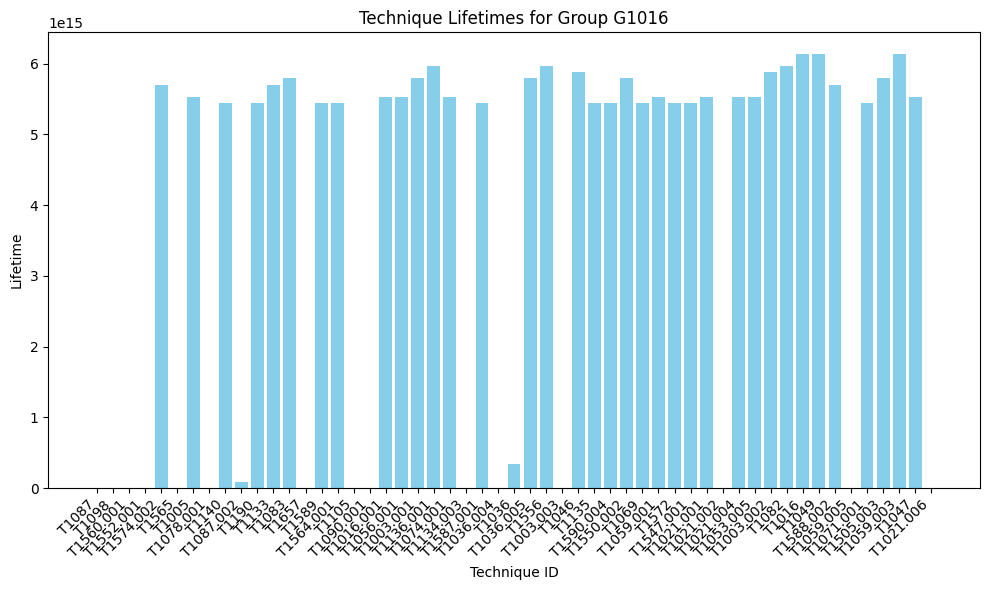

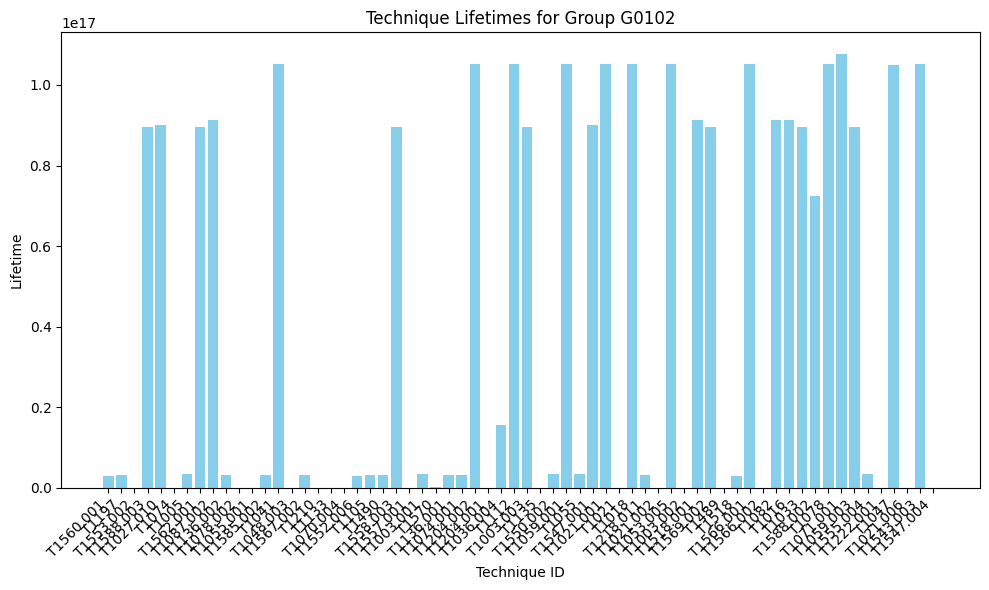

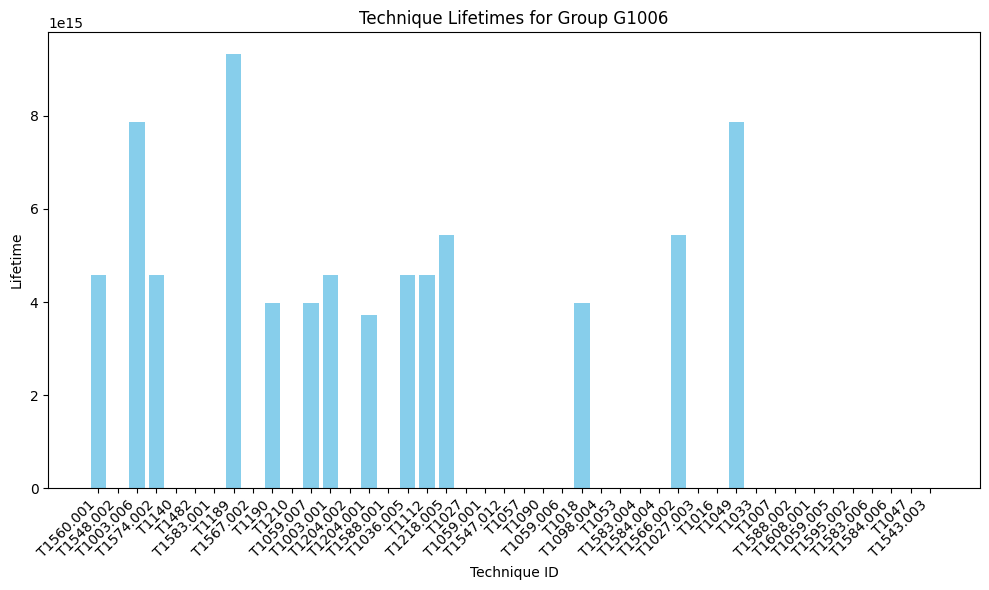

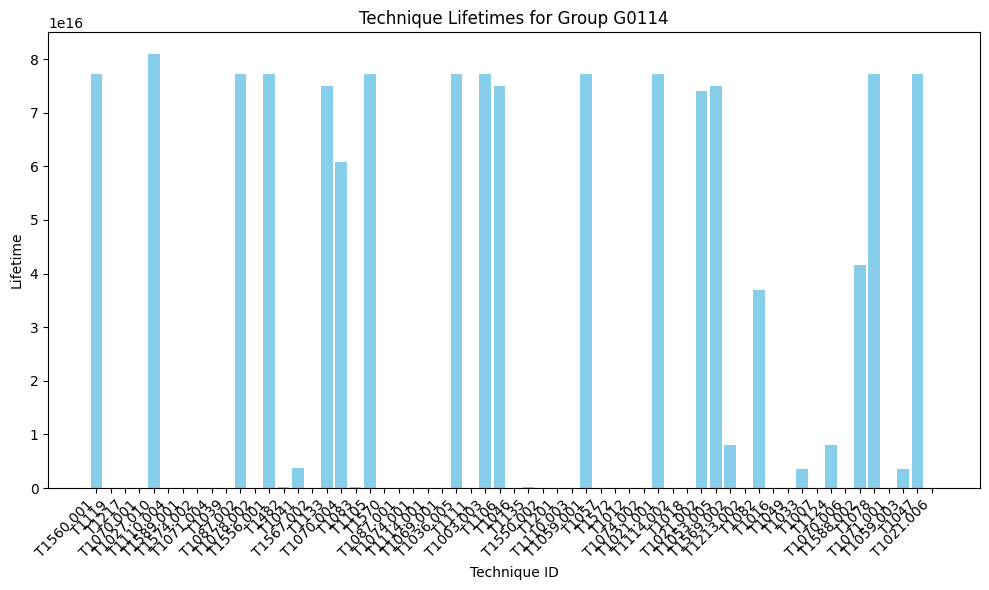

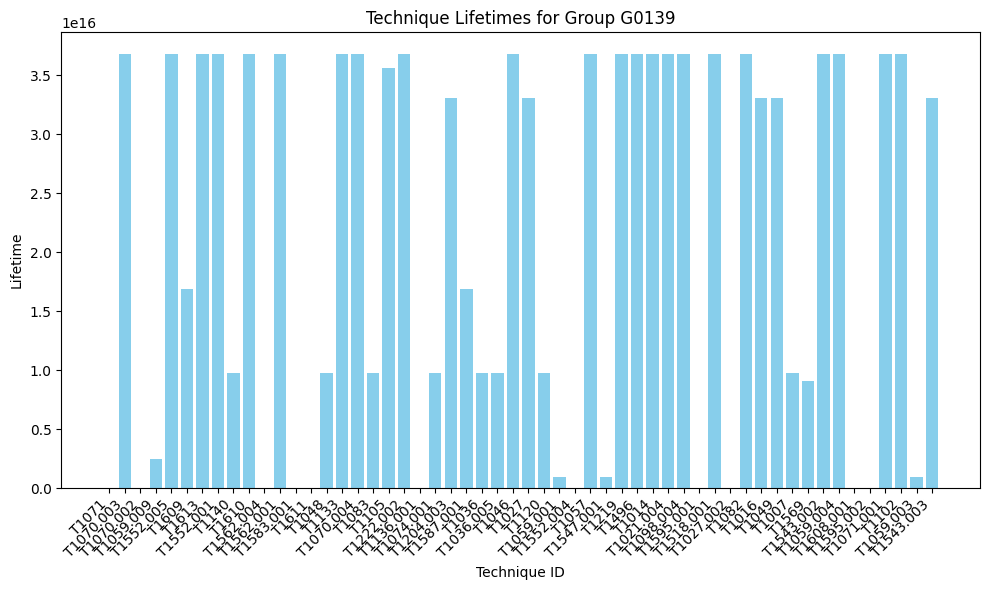

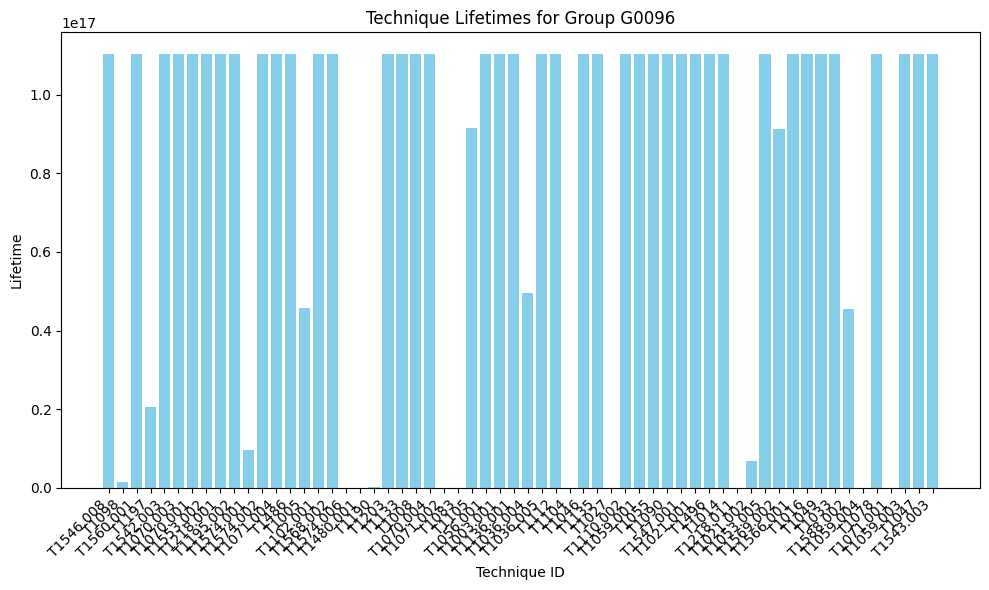

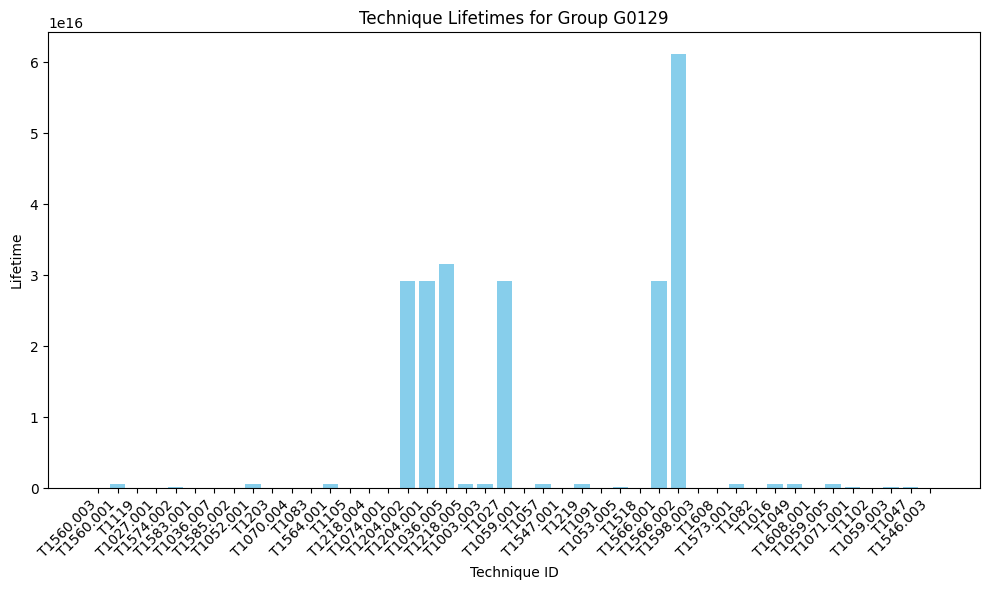

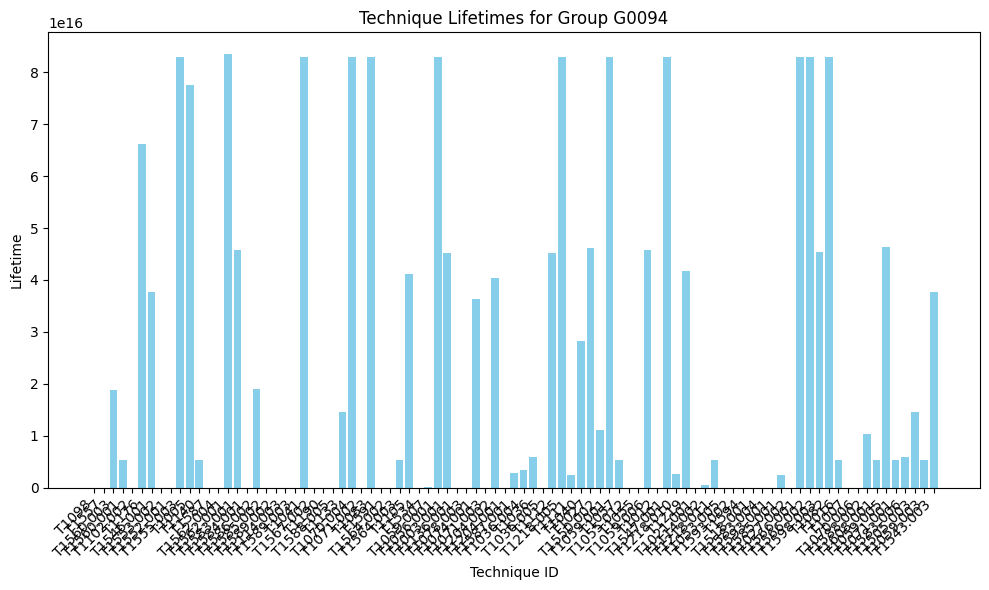

In [30]:
# Convert 'created' and 'last_modified' columns to datetime objects
df['created'] = pd.to_datetime(df['created'])
df['last modified'] = pd.to_datetime(df['last modified'])

# Calculate technique lifetime
df['lifetime'] = df['last modified'] - df['created']

# Iterate over the top 10 groups
for specific_group in top_10_groups['sourceID']:
    group_data = df[df['sourceID'] == specific_group]
    
    if not group_data.empty:
        # Initialize lists to store technique IDs and lifetimes
        technique_ids = []
        lifetimes = []
        
        # Iterate over unique targetIDs within the group
        for specific_technique in group_data['targetID'].unique():
            technique_data = group_data[group_data['targetID'] == specific_technique]
            lifetime = technique_data['lifetime'].values[0] if not technique_data.empty else None
            
            # Append technique ID and lifetime to lists
            technique_ids.append(specific_technique)
            lifetimes.append(lifetime)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(technique_ids, lifetimes, color='skyblue')
        plt.title(f"Technique Lifetimes for Group {specific_group}")
        plt.xlabel('Technique ID')
        plt.ylabel('Lifetime')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for the specified group {specific_group}.")

Top 10 techniques over time

Top 10 targetIDs over time:
targetID
T1204.002    78
T1105        74
T1566.001    71
T1059.001    67
T1588.002    66
T1059.003    57
T1027        50
T1547.001    50
T1036.005    48
T1071.001    47
dtype: int64


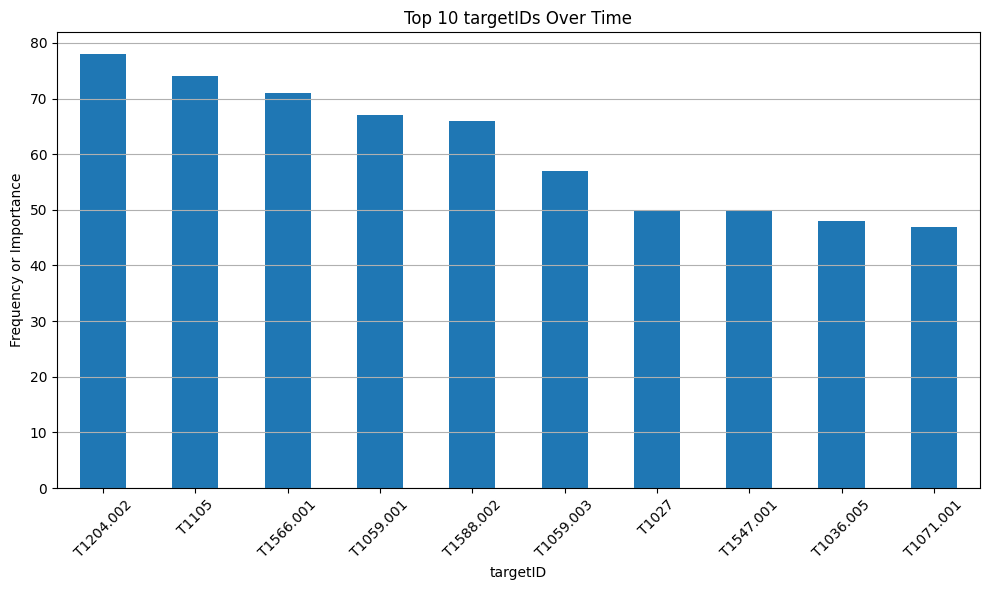

In [34]:
grouped_data = df.groupby('targetID')
target_frequency = grouped_data.size()#number of occurrences of each targetID
top_10_targetIDs = target_frequency.sort_values(ascending=False).head(10)

print("Top 10 targetIDs over time:")
print(top_10_targetIDs)

plt.figure(figsize=(10, 6))
top_10_targetIDs.plot(kind='bar')
plt.title('Top 10 targetIDs Over Time')
plt.xlabel('targetID')
plt.ylabel('Frequency or Importance')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines on the y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Top Groups

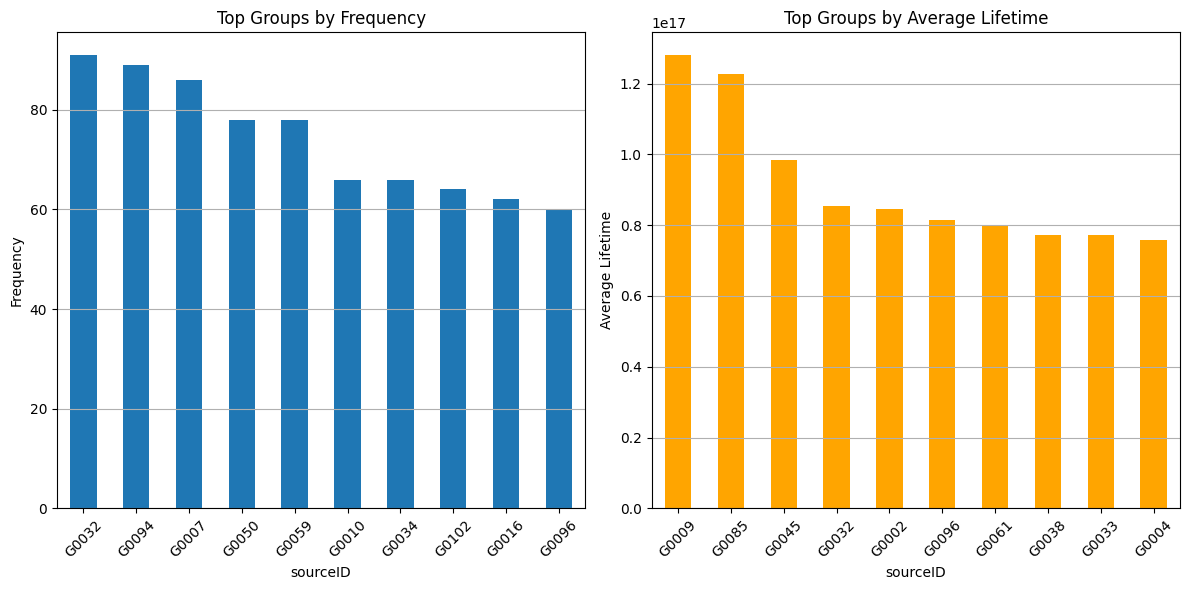

In [35]:
grouped_data = df.groupby('sourceID')
source_frequency = grouped_data.size()
source_avg_lifetime = grouped_data['lifetime'].mean()
top_groups_by_frequency = source_frequency.sort_values(ascending=False).head(10)
top_groups_by_avg_lifetime = source_avg_lifetime.sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))

# Plot the top groups by frequency
plt.subplot(1, 2, 1)
top_groups_by_frequency.plot(kind='bar')
plt.title('Top Groups by Frequency')
plt.xlabel('sourceID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Plot the top groups by average lifetime
plt.subplot(1, 2, 2)
top_groups_by_avg_lifetime.plot(kind='bar', color='orange')
plt.title('Top Groups by Average Lifetime')
plt.xlabel('sourceID')
plt.ylabel('Average Lifetime')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()